# Proxy-Based Spatial Evaluation: Surrogate Reference Values
## Air Quality Spatial Interpolation Assessment

**Date**: January 2, 2026  
**Context**: Sri Lanka Air Quality Monitoring (Battaramulla & Kandy stations)

---

## Overview

This notebook demonstrates **proxy-based spatial evaluation** using LSTM predictions as **surrogate reference values** (NOT true ground truth) to assess spatial interpolation performance.

### Key Concept
> **LSTM predictions serve as proxy benchmarks** to evaluate relative spatial consistency between monitoring stations, not absolute prediction accuracy.

### Evaluation Scenarios
- **Scenario A**: Use only Battaramulla LSTM prediction → predict at Kandy location
- **Scenario B**: Use only Kandy LSTM prediction → predict at Battaramulla location

### Metrics
- **MAE**: Mean Absolute Error
- **RMSE**: Root Mean Square Error  
- **MAPE**: Mean Absolute Percentage Error

## 1. Setup and Imports

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
warnings.filterwarnings("ignore")

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
sys.path.append(str(project_root / "backend"))

print(f"Project root: {project_root}")
print(f"Current working directory: {Path.cwd()}")
print("Libraries imported successfully!")

Project root: c:\Users\nimas\Desktop\Research\air quality (2)\air quality
Current working directory: c:\Users\nimas\Desktop\Research\air quality (2)\air quality\backend
Libraries imported successfully!


## 2. Load Models and Configurations

In [3]:
# Import air quality logic
from backend.air_quality_logic import (
    proxy_based_spatial_evaluation,
    load_artifacts,
    STATION_META
)

print("Air quality logic imported successfully!")

# Display station information
print("\nMonitoring Stations:")
for station, info in STATION_META.items():
    print(f"  {station}: {info['lat']:.6f}, {info['lon']:.6f}")

# Load LSTM models and preprocessors
print("\nLoading LSTM models...")

try:
    # Load PM25 model (pollutant-specific model used across stations)
    model, preprocess, cfg = load_artifacts("PM25")
    print("✓ PM25 model loaded successfully")
    
    models_loaded = True
    
except Exception as e:
    print(f"✗ Error loading PM25 model: {e}")
    print("Please ensure PM25 model files exist in the expected locations")
    models_loaded = False

Air quality logic imported successfully!

Monitoring Stations:
  Battaramulla: 6.901035, 79.926513
  Kandy: 7.292651, 80.635649

Loading LSTM models...
Loading model for PM25...
Model PM25 loaded
✓ PM25 model loaded successfully


## 3. Generate Evaluation Timestamps

We need to select timestamps for evaluation. Let's use a sample period from the available data.

In [4]:
# Load observation data to determine available timestamps
from backend.air_quality_logic import obs

print(f"Total observations: {len(obs):,}")
print(f"Date range: {obs['datetime'].min()} to {obs['datetime'].max()}")

# Get unique timestamps (hourly)
all_timestamps = obs['datetime'].sort_values().unique()
print(f"Unique timestamps: {len(all_timestamps):,}")

# Select evaluation period (e.g., one week in 2023)
start_date = pd.Timestamp("2023-06-01")
end_date = pd.Timestamp("2023-06-07")  # One week

eval_timestamps = [ts for ts in all_timestamps 
                   if start_date <= ts <= end_date]

print(f"\nEvaluation period: {start_date.date()} to {end_date.date()}")
print(f"Evaluation timestamps: {len(eval_timestamps)}")

# Display sample timestamps
print("\nSample timestamps:")
for i, ts in enumerate(eval_timestamps[:5]):
    print(f"  {i+1}. {ts}")
if len(eval_timestamps) > 5:
    print(f"  ... and {len(eval_timestamps)-5} more")

Total observations: 105,216
Date range: 2019-01-01 00:00:00 to 2024-12-31 23:00:00
Unique timestamps: 52,608

Evaluation period: 2023-06-01 to 2023-06-07
Evaluation timestamps: 145

Sample timestamps:
  1. 2023-06-01 00:00:00
  2. 2023-06-01 01:00:00
  3. 2023-06-01 02:00:00
  4. 2023-06-01 03:00:00
  5. 2023-06-01 04:00:00
  ... and 140 more


## 4. Run Proxy-Based Spatial Evaluation

Now we execute the proxy-based evaluation for PM₂.₅ (you can change this to PM₁₀ or NO₂).

In [6]:
# Run evaluation only if models are loaded
if models_loaded:
    # Choose pollutant
    pollutant = "PM25"  # Options: "PM25", "PM10", "NO2"
    
    print(f"Starting proxy-based spatial evaluation for {pollutant}")
    print("=" * 60)
    
    # Execute evaluation
    evaluation_results = proxy_based_spatial_evaluation(
        model=model,
        preprocess=preprocess,
        cfg=cfg,
        timestamps=eval_timestamps,
        pollutant=pollutant
    )
    
    print("\n" + "=" * 60)
    print("EVALUATION COMPLETE")
    print("=" * 60)
    
else:
    print("Models not loaded. Cannot run evaluation.")
    evaluation_results = pd.DataFrame()

Starting proxy-based spatial evaluation for PM25
Running proxy-based spatial evaluation for PM25
Evaluating 145 timestamps...
Processing timestamp 1/145: 2023-06-01 00:00:00
Processing timestamp 51/145: 2023-06-03 02:00:00
Processing timestamp 101/145: 2023-06-05 04:00:00
\nEvaluation complete!
Processed 145 timestamps
Generated 290 prediction pairs
\nSummary metrics:
                  scenario  n_samples    mae   rmse    mape  \
0  A_Battaramulla_to_Kandy        145  5.611  7.094  93.678   
1  B_Kandy_to_Battaramulla        145  6.574  7.965  36.946   

   mape_valid_samples  
0                 145  
1                 145  

EVALUATION COMPLETE


## 5. Results Analysis and Visualization

EVALUATION RESULTS SUMMARY
               scenario  n_samples  mae  rmse  mape  mape_valid_samples
A_Battaramulla_to_Kandy        145 5.61  7.09  93.7                 145
B_Kandy_to_Battaramulla        145 6.57  7.96  36.9                 145


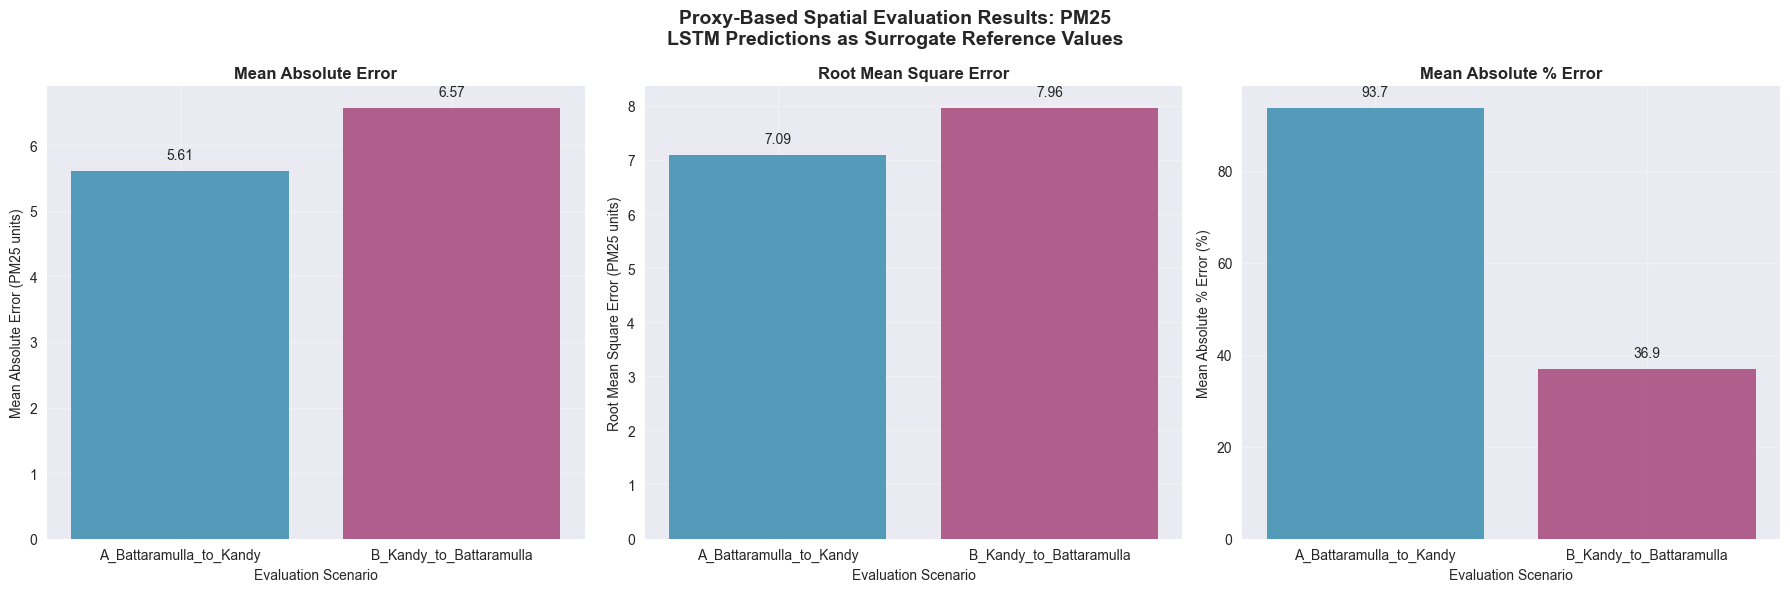


INTERPRETATION

Key Points:
• These metrics measure spatial interpolation consistency
• Lower values indicate better spatial agreement between stations
• LSTM predictions serve as surrogate reference values
• Results assess relative spatial patterns, not absolute accuracy

Scenario Comparison:
• Scenario A (B→K): MAE=5.61, RMSE=7.09, MAPE=93.7%
• Scenario B (K→B): MAE=6.57, RMSE=7.96, MAPE=36.9%
• Scenario A shows better spatial consistency


In [7]:
# Display and analyze results
if not evaluation_results.empty:
    print("EVALUATION RESULTS SUMMARY")
    print("=" * 50)
    
    # Format the results table
    formatted_results = evaluation_results.copy()
    formatted_results = formatted_results.round({
        'mae': 2,
        'rmse': 2,
        'mape': 1
    })
    
    print(formatted_results.to_string(index=False))
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Proxy-Based Spatial Evaluation Results: {pollutant}\n' +
                  'LSTM Predictions as Surrogate Reference Values',
                  fontsize=14, fontweight='bold')
    
    metrics = ['mae', 'rmse', 'mape']
    metric_names = ['Mean Absolute Error', 'Root Mean Square Error', 'Mean Absolute % Error']
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        ax = axes[i]
        
        # Filter out NaN values for MAPE
        plot_data = evaluation_results.dropna(subset=[metric])
        
        if not plot_data.empty:
            bars = ax.bar(plot_data['scenario'], plot_data[metric], 
                         color=['#2E86AB', '#A23B72'], alpha=0.8)
            
            ax.set_title(f'{name}', fontsize=12, fontweight='bold')
            ax.set_ylabel(f'{name} ({pollutant} units)' if i < 2 else f'{name} (%)', fontsize=10)
            ax.set_xlabel('Evaluation Scenario', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars, plot_data[metric]):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + max(plot_data[metric])*0.02,
                       f'{value:.1f}' if metric == 'mape' else f'{value:.2f}',
                       ha='center', va='bottom', fontsize=10)
        
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    print("\n" + "=" * 50)
    print("INTERPRETATION")
    print("=" * 50)
    print("\nKey Points:")
    print("• These metrics measure spatial interpolation consistency")
    print("• Lower values indicate better spatial agreement between stations")
    print("• LSTM predictions serve as surrogate reference values")
    print("• Results assess relative spatial patterns, not absolute accuracy")
    
    # Scenario comparison
    if len(evaluation_results) >= 2:
        scenario_a = evaluation_results.iloc[0]
        scenario_b = evaluation_results.iloc[1]
        
        print(f"\nScenario Comparison:")
        print(f"• Scenario A (B→K): MAE={scenario_a['mae']:.2f}, RMSE={scenario_a['rmse']:.2f}, MAPE={scenario_a['mape']:.1f}%")
        print(f"• Scenario B (K→B): MAE={scenario_b['mae']:.2f}, RMSE={scenario_b['rmse']:.2f}, MAPE={scenario_b['mape']:.1f}%")
        
        if scenario_a['mae'] < scenario_b['mae']:
            print("• Scenario A shows better spatial consistency")
        else:
            print("• Scenario B shows better spatial consistency")
    
else:
    print("No evaluation results to display")

## 6. Methodological Notes

### Important Distinctions
- **Surrogate Reference Values**: LSTM predictions are used as proxy benchmarks, NOT true measurements
- **Spatial Consistency**: This evaluates how well spatial interpolation preserves relative patterns
- **NOT Validation**: This is NOT true spatial cross-validation with ground truth data

### Use Cases
- Assess spatial interpolation method performance
- Compare different spatial algorithms
- Evaluate consistency between monitoring stations
- Support method selection for air quality mapping

### Limitations
- Depends on LSTM prediction quality as reference
- Measures relative consistency, not absolute accuracy
- Limited to available monitoring station pairs
- Temporal variability may affect spatial relationships

## 7. Integration with FastAPI Pipeline

This evaluation can be integrated into your existing FastAPI pipeline:

```python
# Example FastAPI endpoint
@app.post("/evaluate-spatial")
async def evaluate_spatial_performance(pollutant: str = "PM25"):
    # Get recent timestamps
    timestamps = get_recent_timestamps(hours=168)  # Last week
    
    # Run evaluation
    results = proxy_based_spatial_evaluation(
        model_b, model_k, preprocess_b, preprocess_k,
        cfg_b, cfg_k, timestamps, pollutant
    )
    
    return {"evaluation_results": results.to_dict('records')}
```

This provides ongoing monitoring of spatial interpolation performance.